In [136]:
import cloudytab
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import astropy.units as u
import numpy as np
# sns.set_palette("magma", n_colors=3)

In [137]:
datapath = Path.cwd().parent / "cloudy"

Set up default property cycle for the three models

In [138]:
from cycler import cycler

# Define a custom property cycle
custom_cycler = (
    cycler(color=["xkcd:emerald green", "xkcd:bright blue", "xkcd:red"]) +
    cycler(linestyle=["-", "--", "-."]) +
    cycler(linewidth=[1.2, 1.5, 1.7])
)
plt.rc("axes", prop_cycle=custom_cycler)


## Three models that are identical apart from the abundances

Set up options for the amplitude of the metallicity fluctuations

In [139]:
from enum import StrEnum

class Zamplitude(StrEnum):
    SIX = "Z06fluct"
    FIFTEEN = "Z15fluct"
    THIRTY = "Z30fluct"
    SIXTY = "Z60fluct"
    ONE_TWENTY = "Z120fluct"

Options for the density law of the models set to plot: constant density or constant pressure.

In [140]:
class DensityLaw(StrEnum):
    CONSTANT_DENSITY = "n"
    CONSTANT_PRESSURE = "p"

Options for Ha luminosity normalization. The LOW option assumes covering fraction of unity and use (1 - sigma) times observed flux.

In [141]:
class LuminosityNorm(StrEnum):
    STANDARD = "lha"
    LOW = "llha"
    FIXED_PRESSURE = "nT62"

In [142]:
class NebularClass(StrEnum):
    OU5_ABUNDANCES = "ou5a"
    OU5_NO_INDUCED = "ou5ani"

class Lstar(StrEnum):
    HIGH = "L660"
    LOW = "L400"

### Choose which *options* to use. 
***Edit following cell and rerun all following cells to produce each different graph***

In [143]:
zamp = Zamplitude.ONE_TWENTY
dlaw = DensityLaw.CONSTANT_DENSITY
lnorm = LuminosityNorm.LOW
neb = NebularClass.OU5_ABUNDANCES
lstar = Lstar.HIGH
frozen_ylims = True

### Read in the three Cloudy models

Construct components of the model file names for the three models (no fluctuations, long wavelength, short wavelength)

In [144]:
suffixes = ["", f"-{zamp}-long", f"-{zamp}-short"]
model_id = f"T115-L660-{dlaw}-{lnorm}"

Load the cloudy models

In [145]:
models = [cloudytab.CloudyModel(datapath / f"{neb}-{model_id}{s}") for s in suffixes]

In [146]:
models[0].data.keys()

dict_keys(['rad', 'abun', 'dr', 'pre', 'cont', 'ovr', 'ems'])

### Select the columns we want to plot across different output files

In [147]:
models[0].data["ems"].columns

<TableColumns names=('depth','H  1 6562.80A','Ca B 6562.81A','H  1 4861.32A','He 2 4685.68A','He 2 6560.01A','He 1 5015.68A','O  3 5006.84A','O  3 4363.21A','O 3R 4363.00A','O 3C 4363.00A','O  2 7319.99A','N  2 6583.45A','Ar 4 4711.26A','C  2 4267.00A','C  2 4267.26A','O 2R 4651.00A','O 2P 4651.00A','O  2 4651.00A','O  2 4650.84A','O  2 4094.00A','O  1 7771.94A')>

Ratio of 5007/4363 from pure recombination contribution (Pequignot+1991) to account for the fact that Cloudy does not calculate the recombination contribution to 5007

In [148]:
recomb_5007_4363 = 3.4
cx_5007_4363 = 3.4 # CHECK THIS!!!!

In [149]:
def get_plot_data(model):
    plot_data = {}
    plot_data["radius"] = model.data["rad"]["radius"] * u.cm.to(u.pc)
    plot_data["O/H"] = 10 ** (model.data["abun"]["OXYG"] - model.data["abun"]["abund H"])
    for _column in ["Te", "HeIII", "eden", "O3", "O2", "O4"]:
        plot_data[_column] = model.data["ovr"][_column]
    plot_data[r"e(H$\beta$)"] = model.data["ems"]["H  1 4861.32A"]
    plot_data[r"e(He II $\lambda$4686)"] = model.data["ems"]["He 2 4685.68A"]
    plot_data[r"e([O III] $\lambda$5007)"] = (
        model.data["ems"]["O  3 5006.84A"]
        + recomb_5007_4363 * model.data["ems"]["O 3R 4363.00A"]
        + cx_5007_4363 * model.data["ems"]["O 3C 4363.00A"]
    )        
    plot_data[r"e([O III] $\lambda$4363)"] = (
        model.data["ems"]["O  3 4363.21A"] 
        + model.data["ems"]["O 3R 4363.00A"]
        + model.data["ems"]["O 3C 4363.00A"]
    )
    plot_data[r"4363-col"] = (
        model.data["ems"]["O  3 4363.21A"]
        # - model.data["ems"]["O 3R 4363.00A"]
        # - model.data["ems"]["O 3C 4363.00A"]
    )        
    plot_data[r"e(O II $\lambda\lambda$4651+)"] = model.data["ems"]["O  2 4651.00A"]
    # plot_data[r"e(O II $\lambda$4651)"] = model.data["ems"]["O  2 4650.84A"]
        
    return plot_data

In [150]:
datasets = [get_plot_data(m) for m in models]

In [151]:
peaks = ((10**16.698) * np.arange(6) * u.cm).to_value(u.pc) + datasets[0]["radius"][0]
peaks

array([0.06003349, 0.07620124, 0.09236898, 0.10853673, 0.12470447,
       0.14087222])

### Plot physical variables versus radius

In [152]:
ylabel_dict = dict(y=0.5, rotation=0, ha="right", va="center")

In [153]:
tdict = {
    DensityLaw.CONSTANT_PRESSURE: "pressure",
    DensityLaw.CONSTANT_DENSITY: "density",
    Zamplitude.SIX: 6,
    Zamplitude.FIFTEEN: 15,
    Zamplitude.THIRTY: 30,
    Zamplitude.SIXTY: 60,
    Zamplitude.ONE_TWENTY: 120,
}

In [154]:
tdict[dlaw], tdict[zamp]

('density', 120)

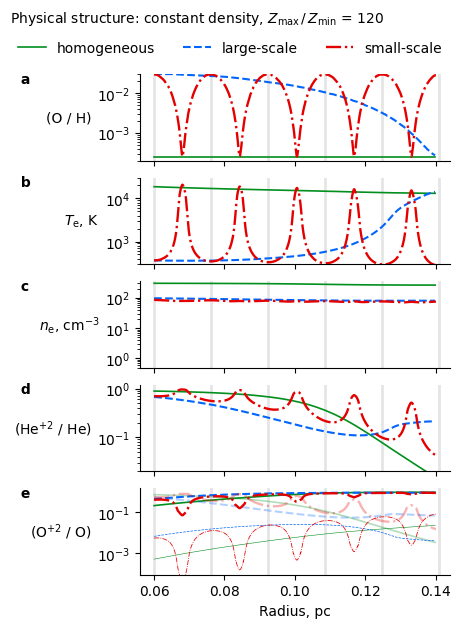

In [168]:
ny = 5
fig, axes = plt.subplots(ny, 1, sharex=True, figsize=(4, 1.3*ny))
for data in datasets:
    axes[0].plot("radius", "O/H", data=data)
    axes[0].set_ylabel("(O / H)", **ylabel_dict)
    axes[1].plot("radius", "Te", data=data)
    axes[1].set_ylabel(r"$T_\mathrm{e}$, K", **ylabel_dict)
    axes[2].plot("radius", "eden", data=data)
    axes[2].set_ylabel(r"$n_\mathrm{e}$, cm$^{-3}$", **ylabel_dict)
    axes[3].plot("radius", "HeIII", data=data)
    axes[3].set_ylabel(r"(He$^{+2}$ / He)", **ylabel_dict)
    line, = axes[4].plot("radius", "O3", data=data)
    axes[4].plot(
        data["radius"], data["O2"], 
        lw=line.get_linewidth()/3, c=line.get_color(), ls=line.get_linestyle(),
    )
    axes[4].plot(
        data["radius"], data["O4"], 
        alpha=0.3,
        lw=line.get_linewidth(), c=line.get_color(), ls=line.get_linestyle(),
    )
    axes[4].set_ylabel(r"(O$^{+2}$ / O)", **ylabel_dict)
        

if frozen_ylims:
    axes[0].set_ylim(2e-4, 3e-2)
    axes[1].set_ylim(300, 30_000)
    axes[2].set_ylim(0.5, 350)
    axes[3].set_ylim(0.02, 1.2)
    axes[4].set_ylim(0.9e-4, 1.5)

for ax, label in zip(axes, "abcde"):
    ax.text(-0.4, 0.9, " " + label, fontweight="heavy", transform=ax.transAxes)
    ax.set_yscale("log")
    for peak in peaks:
        ax.axvline(peak, color="k", lw=2, alpha=0.1, zorder=-100)


# single legend (from the first axes)
handles, labels = axes[0].get_legend_handles_labels()
labels = ["homogeneous", "large-scale", "small-scale"]
fig.legend(
    handles, labels, 
    ncol=3, frameon=False, loc="upper center", bbox_to_anchor=(0.35, 0.95)
)
sns.despine()
axes[-1].set_xlabel("Radius, pc")
title = ( 
    fr"Physical structure: constant "
    fr"{tdict[dlaw]}, $Z_\mathrm{{max}} \,/\, Z_\mathrm{{min}}$ = {tdict[zamp]}"
)
fig.suptitle(title, x=-0.2, ha="left", fontsize="medium")
fig.savefig(f"{neb}-cloudy-{model_id}-{zamp}-physical.pdf", bbox_inches="tight")

In [156]:
fig.suptitle?

Signature: fig.suptitle(t, **kwargs)
Docstring:
Add a centered super title to the figure.

Parameters
----------
t : str
    The super title text.
x : float, default: 0.5
    The x location of the text in figure coordinates.
y : float, default: 0.98
    The y location of the text in figure coordinates.
horizontalalignment, ha : {'center', 'left', 'right'}, default: center
    The horizontal alignment of the text relative to (*x*, *y*).
verticalalignment, va : {'top', 'center', 'bottom', 'baseline'}, default: top
    The vertical alignment of the text relative to (*x*, *y*).
fontsize, size : default: :rc:`figure.titlesize`
    The font size of the text. See `.Text.set_size` for possible
    values.
fontweight, weight : default: :rc:`figure.titleweight`
    The font weight of the text. See `.Text.set_weight` for possible
    values.

Returns
-------
text
    The `.Text` instance of the super title.

Other Parameters
----------------
fontproperties : None or dict, optional
    A dict of f

### Plot line emissivity versus radius

In [157]:
emlines = [k for k in datasets[0].keys() if k.startswith("e(")]

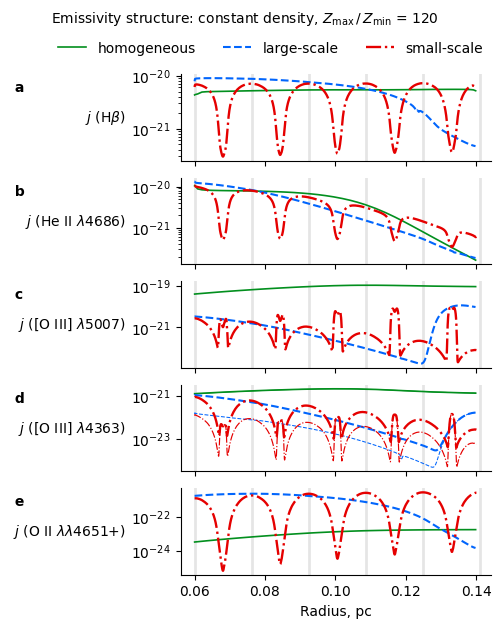

In [158]:
ny = len(emlines)
fig, axes = plt.subplots(ny, 1, sharex=True, figsize=(4, 1.3*ny))
for emline, ax in zip(emlines, axes):
    for data in datasets:
        line, = ax.plot(data["radius"], data[emline], label="xxx")
        if "4363" in emline:
            ax.plot(
                data["radius"], data["4363-col"],
                lw=0.5*line.get_linewidth(), c=line.get_color(), ls=line.get_linestyle(),
            )
            
    ax.set_ylabel(emline.replace("e(", r"$j$ ("), **ylabel_dict)

for ax, label in zip(axes, "abcde"):
    ax.text(-0.55, 0.8, " " + label, fontweight="heavy", transform=ax.transAxes)
    # ax.set_ylim(None, None)
    # ymin, ymax = ax.get_ylim()
    # ax.set_ylim(ymax/200, ymax)
    ax.set_yscale("log")
    for peak in peaks:
        ax.axvline(peak, color="k", lw=2, alpha=0.1, zorder=-100)

axes[-1].set_xlabel("Radius, pc")
handles, labels = axes[0].get_legend_handles_labels()
labels = ["homogeneous", "large-scale", "small-scale"]
fig.legend(
    handles, 
    labels, 
    ncol=3, 
    frameon=False, 
    loc="upper center", 
    bbox_to_anchor=(0.35, 0.95),
)
title = ( 
    fr"Emissivity structure: constant "
    fr"{tdict[dlaw]}, $Z_\mathrm{{max}} \,/\, Z_\mathrm{{min}}$ = {tdict[zamp]}"
)
fig.suptitle(title, x=-0.2, ha="left", fontsize="medium")

sns.despine()
fig.savefig(f"{neb}-cloudy-{model_id}-{zamp}-emission.pdf", bbox_inches="tight")

### Plot emission line ratios versus radius

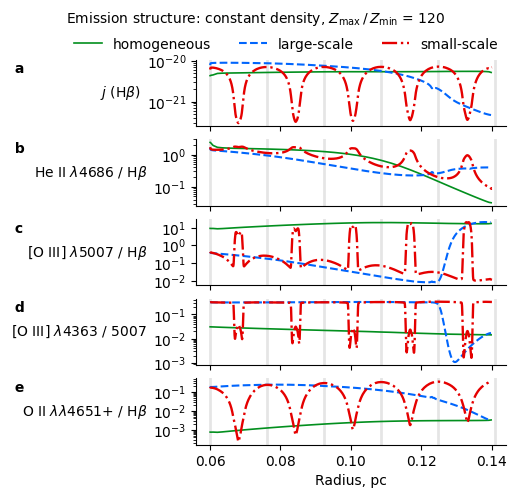

In [159]:
ny = len(emlines)
fig, axes = plt.subplots(ny, 1, sharex=True, figsize=(4, 1*ny))
for emline, ax in zip(emlines, axes):
    if "beta" in emline:
        for data in datasets:
            ax.plot(data["radius"], data[emline], label="xxx")
        ax.set_ylabel(emline.replace("e(", r"$j$ ("), y=0.5, rotation=0, ha="right", va="center")
    elif "4363" in emline:
        for data in datasets:
            ax.plot(data["radius"], data[emline] / data["e([O III] $\lambda$5007)"])
        ax.set_ylabel(
            (emline
             .replace("e(", r"")
             .replace(")", r" / 5007")
            ), 
            y=0.5, rotation=0, ha="right", va="center")
    else:
        for data in datasets:
            ax.plot(data["radius"], data[emline] / data[r"e(H$\beta$)"])
        ax.set_ylabel(
            (emline
             .replace("e(", r"")
             .replace(")", r" / H$\beta$")
            ), 
            y=0.5, rotation=0, ha="right", va="center")

min_factor = 30
for ax, label in zip(axes, "abcde"):
    ax.text(-0.6, 0.8, " " + label, fontweight="heavy", transform=ax.transAxes)
    ax.set_yscale("log")
    ymin, ymax = ax.get_ylim()
    if ymax < min_factor * ymin:
        ax.set_ylim(ymax / min_factor, ymax)
    if "/" in ax.get_ylabel():
        ylmin, ylmax = [np.log10(_) for _ in ax.get_ylim()]
        lticks = np.arange(int(ylmin), int(ylmax+1))
        ax.set_yticks(10.0**lticks)
    #
    for peak in peaks:
        ax.axvline(peak, color="k", lw=2, alpha=0.1, zorder=-100)

axes[-1].set_xlabel("Radius, pc")

handles, labels = axes[0].get_legend_handles_labels()
labels = ["homogeneous", "large-scale", "small-scale"]
fig.legend(
    handles, 
    labels, 
    ncol=3, 
    frameon=False, 
    loc="upper center", 
    bbox_to_anchor=(0.35, 0.95),
)
title = ( 
    fr"Emission structure: constant "
    fr"{tdict[dlaw]}, $Z_\mathrm{{max}} \,/\, Z_\mathrm{{min}}$ = {tdict[zamp]}"
)
fig.suptitle(title, x=-0.2, ha="left", fontsize="medium")
sns.despine()
fig.savefig(f"{neb}-cloudy-{model_id}-{zamp}-eratios.pdf", bbox_inches="tight")

### Calculate Ha-weighted temperature

In [160]:
Tdata = []
for m, s in zip(models, suffixes):
    r = m.data["rad"]["radius"]
    eha = m.data["ems"]["H  1 6562.80A"]
    T = m.data["ovr"]["Te"]
    dVdr = 4 * np.pi * r ** 2
    L_ha = np.trapz(eha * dVdr, r)
    T_ha = np.trapz(T * eha * dVdr, r) / L_ha
    Tdata.append(
        {"model": model_id + s, 
         "T(Ha)": T_ha, 
         "log10(L(Ha))": np.log10(L_ha)}
    )

In [161]:
from astropy.table import Table
Table(Tdata)

model,T(Ha),log10(L(Ha))
str32,float64,float64
T115-L660-n-llha,14638.427615259654,33.662017827393406
T115-L660-n-llha-Z120fluct-long,872.3694003117946,33.64735978209754
T115-L660-n-llha-Z120fluct-short,641.2644133441642,33.65010808306873


### Earlier version that plots all the emission lines

In [162]:
m0, mm, m = models

In [163]:
edata = m.data["ems"]
edata0 = m0.data["ems"]
edata1 = mm.data["ems"]

In [164]:
elines = list(edata.columns[1:])
elines

['H  1 6562.80A',
 'Ca B 6562.81A',
 'H  1 4861.32A',
 'He 2 4685.68A',
 'He 2 6560.01A',
 'He 1 5015.68A',
 'O  3 5006.84A',
 'O  3 4363.21A',
 'O 3R 4363.00A',
 'O 3C 4363.00A',
 'O  2 7319.99A',
 'N  2 6583.45A',
 'Ar 4 4711.26A',
 'C  2 4267.00A',
 'C  2 4267.26A',
 'O 2R 4651.00A',
 'O 2P 4651.00A',
 'O  2 4651.00A',
 'O  2 4650.84A',
 'O  2 4094.00A',
 'O  1 7771.94A']

In [165]:
radius = m.data["rad"]["radius"] * u.cm.to(u.pc)
radius0 = m0.data["rad"]["radius"] * u.cm.to(u.pc)
radius1 = mm.data["rad"]["radius"] * u.cm.to(u.pc)


/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_59568/2221142214.py:8: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, 1.2*edata[eline].max())


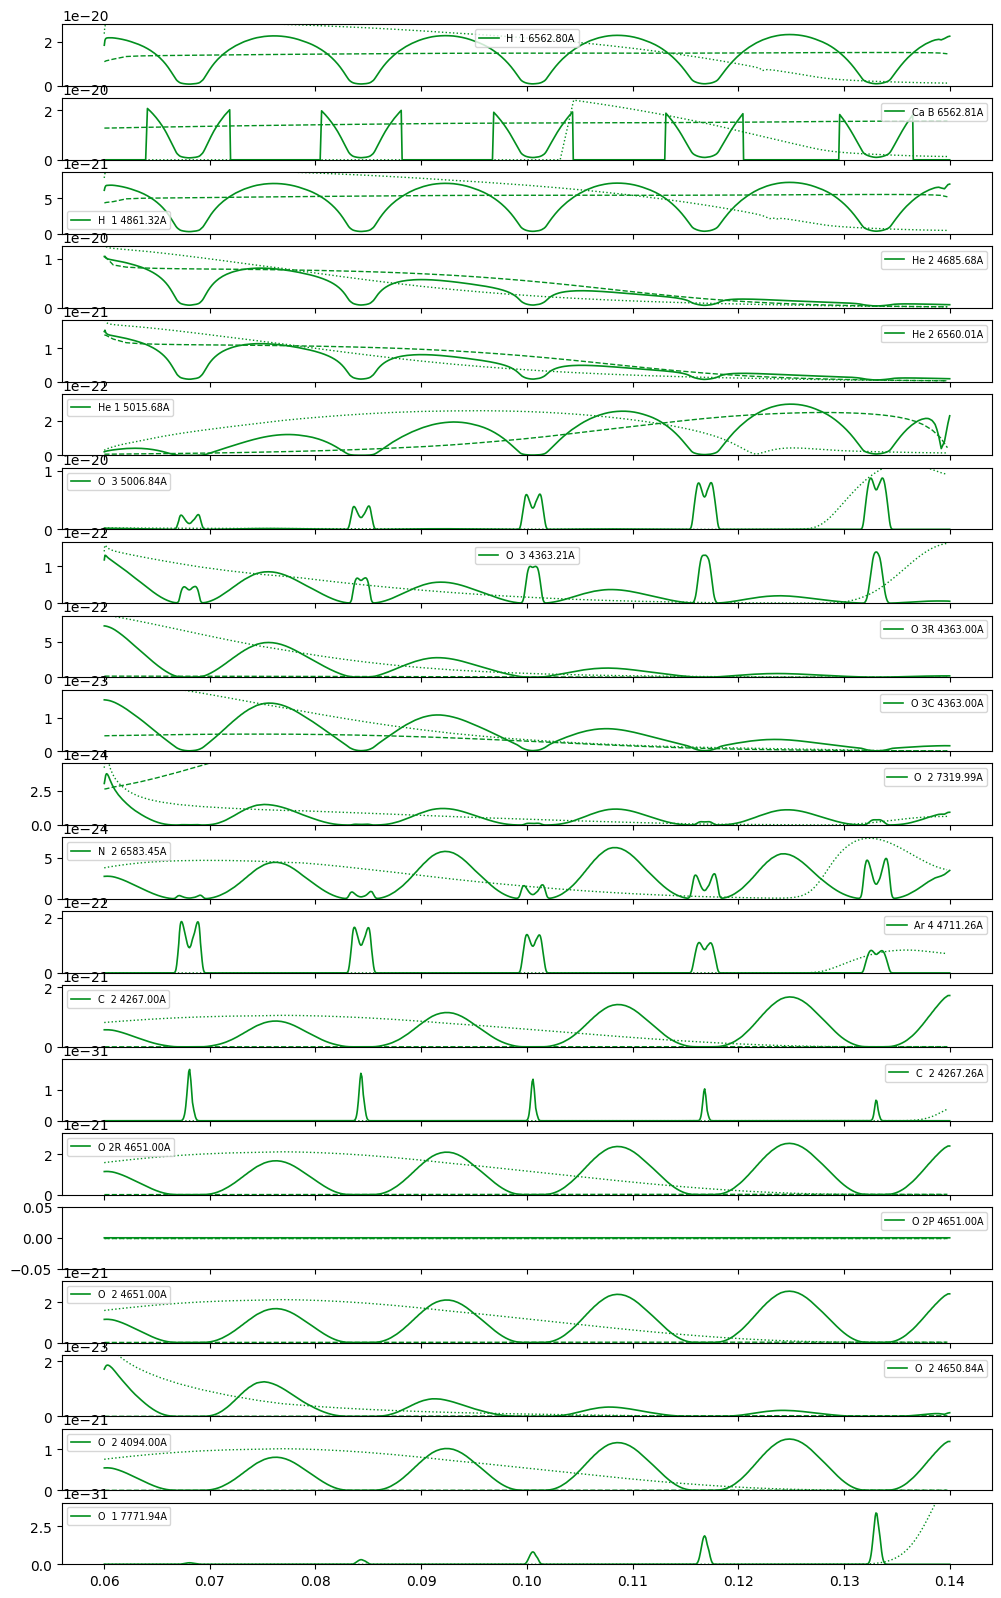

In [166]:
fig, axes = plt.subplots(len(elines), 1, figsize=(12, 20), sharex=True)
for ax, eline in zip(axes, elines):
    scale = 1
    line, = ax.plot(radius, edata[eline] / scale, label=eline)
    ax.plot(radius0, edata0[eline] / scale, label=None, color=line.get_color(), lw=1, ls="dashed")
    ax.plot(radius1, edata1[eline] / scale, label=None, color=line.get_color(), lw=1, ls="dotted")
    ax.set_yscale("linear")
    ax.set_ylim(0, 1.2*edata[eline].max())
    ax.legend(ncol=4, fontsize="x-small")

In [167]:
m.skipped

{'het': 'Table.read() raised InconsistentTableError',
 'col': 'Table.read() raised InconsistentTableError',
 'res': 'Table.read() raised InconsistentTableError'}